In [1]:
from family import FamilyTree


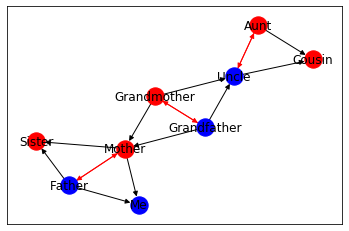

In [2]:
# This example demonstrates the creation of the family tree using its inner methods

tree = FamilyTree()
tree.add_person("Grandfather", "male")
tree.marry(("Grandfather", "male"), ("Grandmother", "female"))
tree.have_child("Mother", "female", "Grandfather")
tree.have_child("Uncle", "male", "Grandmother")
tree.marry(("Father", "male"), ("Mother", "female"))
tree.marry(("Uncle", "male"), ("Aunt", "female"))
tree.have_child("Sister", "female", "Father")
tree.have_child("Me", "male", "Father")
tree.have_child("Cousin", "female", "Uncle")

tree.draw()


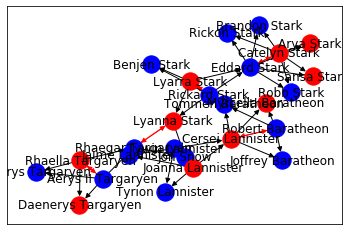

In [3]:
# Here we demonstrate the feature of loading the family tree definition from json file on the family tree from Game of Thrones series

got = FamilyTree("game_of_thrones.json")
got.draw()


In [5]:
# We can see the relation between any two family members (too distant relatives are identified as "far relatives")

def print_relation(ft, p1, p2):
    try:
        print("{} is {} of {}".format(p2, ft.who_is_to(p1, p2), p1))
    except Exception as e:
        print(e)

print_relation(got, "Joffrey Baratheon", "Sansa Stark")
print_relation(got, "Robert Baratheon", "Jaime Lannister")
print_relation(got, "Jon Snow", "Eddard Stark")
print_relation(got, "Jon Snow", "Catelyn Stark")
print_relation(tree, "Me", "Grandfather")
print_relation(tree, "Mother", "Cousin")


Joffrey Baratheon and Sansa Stark are not relatives
Jaime Lannister is brother-in-law of Robert Baratheon
Eddard Stark is uncle of Jon Snow
Catelyn Stark is aunt of Jon Snow
Grandfather is grandfather of Me
Cousin is niece of Mother
